In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Set dataset directory
data_dir = './Tea_Leaf_Disease'

# Define image size and batch size
img_height, img_width = 256, 256
batch_size =2

# ImageDataGenerators for train, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(data_dir, 'validation'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

def build_model(hp):
    model = Sequential()

    # Add convolutional layers
    for i in range(hp.Int('conv_layers', 2, 4)):  
        kernel_size_choice = hp.Choice('kernel_size_' + str(i), ['3x3', '5x5'])  # Choose kernel size as string
        # Directly map the string to a tuple of integers for the kernel size
        if kernel_size_choice == '3x3':
            kernel_size = (3, 3)
        elif kernel_size_choice == '5x5':
            kernel_size = (5, 5)

        # Set the input shape only for the first convolutional layer (i == 0)
        if i == 0:
            model.add(Conv2D(
                filters=hp.Int('filters_' + str(i), 32, 128, step=32),  
                kernel_size=kernel_size, 
                activation=hp.Choice('activation', ['relu', 'tanh']),
                input_shape=(img_height, img_width, 3)  # Explicit input shape for first layer
            ))
        else:
            model.add(Conv2D(
                filters=hp.Int('filters_' + str(i), 32, 128, step=32),  
                kernel_size=kernel_size, 
                activation=hp.Choice('activation', ['relu', 'tanh'])
            ))
        
        model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output of the last convolutional layer
    model.add(Flatten())

    # Add fully connected layers
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation=hp.Choice('dense_activation', ['relu', 'tanh'])
    ))

    # Add dropout layer
    model.add(Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(2, activation='softmax'))  # Adjust number of classes accordingly

    # Compile the model with a chosen optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])

    if optimizer == 'adam':
        opt = Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    else:
        opt = SGD(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create a log directory for TensorBoard
log_dir = "logs"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Instantiate the Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    hyperband_iterations=2,  
    directory='hyperband_dir',
    project_name='cnn_tuning'
)

# Add TensorBoard callback to monitor training progress
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=0
)

Found 28933 images belonging to 2 classes.
Found 1207 images belonging to 2 classes.
Reloading Tuner from hyperband_dir\cnn_tuning\tuner0.json


In [ ]:
# Search for the best hyperparameters using the training and validation sets
tuner.search(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[tensorboard_callback, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters and TensorBoard callback
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[tensorboard_callback, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Save the trained model
model.save('best_cnn_model.h5')

# Optionally, print the best hyperparameters
print("Best hyperparameters:", best_hps.values)

Trial 50 Complete [00h 28m 44s]
val_accuracy: 0.5020712614059448

Best val_accuracy So Far: 0.9444904923439026
Total elapsed time: 1d 00h 54m 56s

Search: Running Trial #51

Value             |Best Value So Far |Hyperparameter
3                 |4                 |conv_layers
5x5               |5x5               |kernel_size_0
128               |32                |filters_0
relu              |relu              |activation
3x3               |5x5               |kernel_size_1
128               |32                |filters_1
192               |128               |dense_units
tanh              |relu              |dense_activation
0.3               |0.3               |dropout_rate
sgd               |adam              |optimizer
0.0011082         |0.00010207        |learning_rate
3x3               |5x5               |kernel_size_2
64                |96                |filters_2
3x3               |5x5               |kernel_size_3
32                |64                |filters_3
20                

KeyboardInterrupt: 

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import os

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(
    train_generator,
    epochs=6,
    validation_data=validation_generator,
    callbacks=[
        tensorboard_callback,
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

# Save the trained model
model.save('best_cnn_model3.h5')

# Optionally, print the best hyperparameters
print("Best hyperparameters:", best_hps.values)

Epoch 1/20
14467/14467 [==============================] - 161s 11ms/step - loss: 0.4567 - accuracy: 0.7808 - val_loss: 0.2739 - val_accuracy: 0.8906
Epoch 2/20
14467/14467 [==============================] - 122s 8ms/step - loss: 0.2761 - accuracy: 0.8872 - val_loss: 0.2024 - val_accuracy: 0.9171
Epoch 3/20
14467/14467 [==============================] - 121s 8ms/step - loss: 0.2213 - accuracy: 0.9129 - val_loss: 0.1646 - val_accuracy: 0.9387
Epoch 4/20
14467/14467 [==============================] - 129s 9ms/step - loss: 0.1880 - accuracy: 0.9265 - val_loss: 0.1798 - val_accuracy: 0.9321
Epoch 5/20
14467/14467 [==============================] - 122s 8ms/step - loss: 0.1627 - accuracy: 0.9382 - val_loss: 0.1645 - val_accuracy: 0.9453
Epoch 6/20
14467/14467 [==============================] - 122s 8ms/step - loss: 0.1480 - accuracy: 0.9464 - val_loss: 0.1379 - val_accuracy: 0.9544
Epoch 7/20
14467/14467 [==============================] - 122s 8ms/step - loss: 0.1374 - accuracy: 0.9527 - val

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 252, 252, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 122, 122, 32)      25632     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 57, 57, 96)        76896     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 96)      

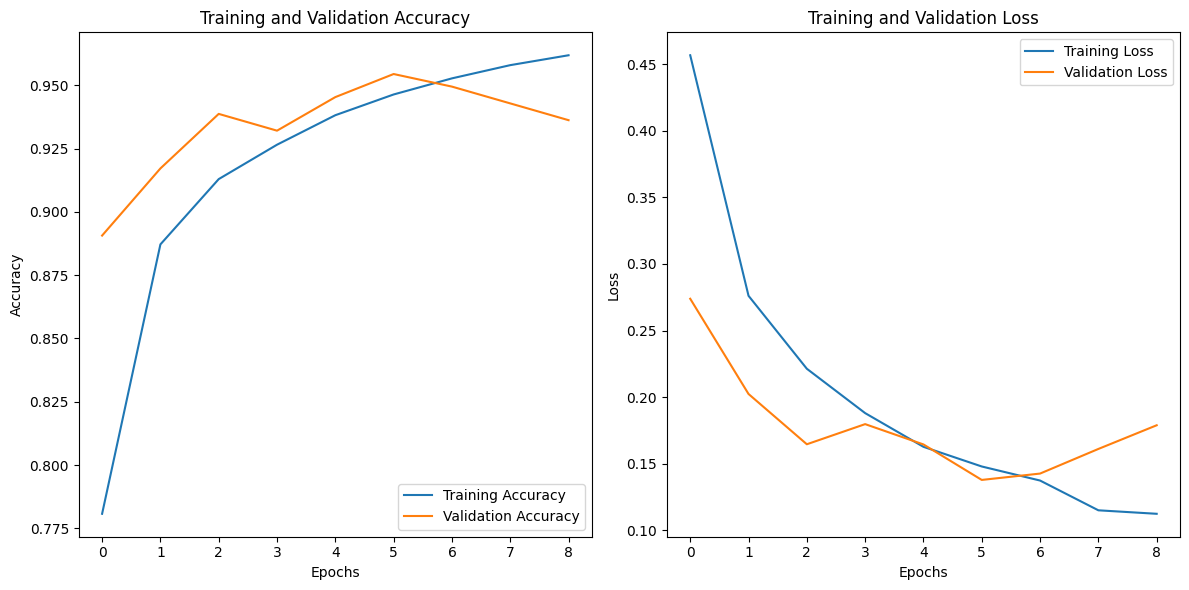

In [8]:
# Extract training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(train_acc))

# Plot accuracy curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot loss curves
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the plots
plt.tight_layout()
plt.show()


Found 588 images belonging to 2 classes.
Found 1207 images belonging to 2 classes.
294/294 [==============================] - 2s 7ms/step
Validation Classification Report:
              precision    recall  f1-score   support

     Healthy       0.97      0.94      0.95       606
    Infected       0.94      0.97      0.95       601

    accuracy                           0.95      1207
   macro avg       0.95      0.95      0.95      1207
weighted avg       0.95      0.95      0.95      1207

Test Classification Report:
              precision    recall  f1-score   support

     Healthy       0.92      0.74      0.82       299
    Infected       0.78      0.93      0.85       289

    accuracy                           0.84       588
   macro avg       0.85      0.84      0.84       588
weighted avg       0.85      0.84      0.84       588



ValueError: Found input variables with inconsistent numbers of samples: [1207, 2414]

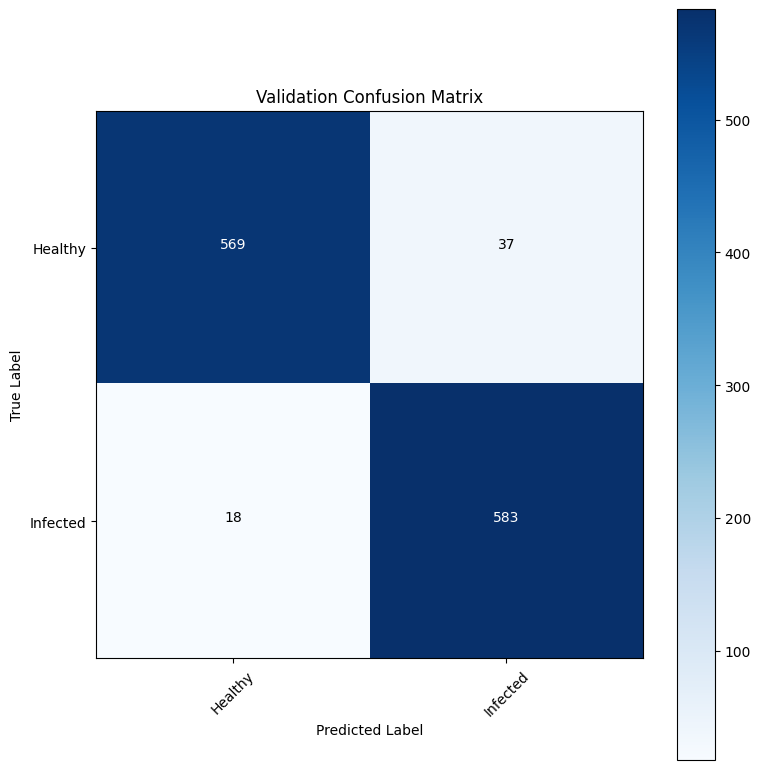

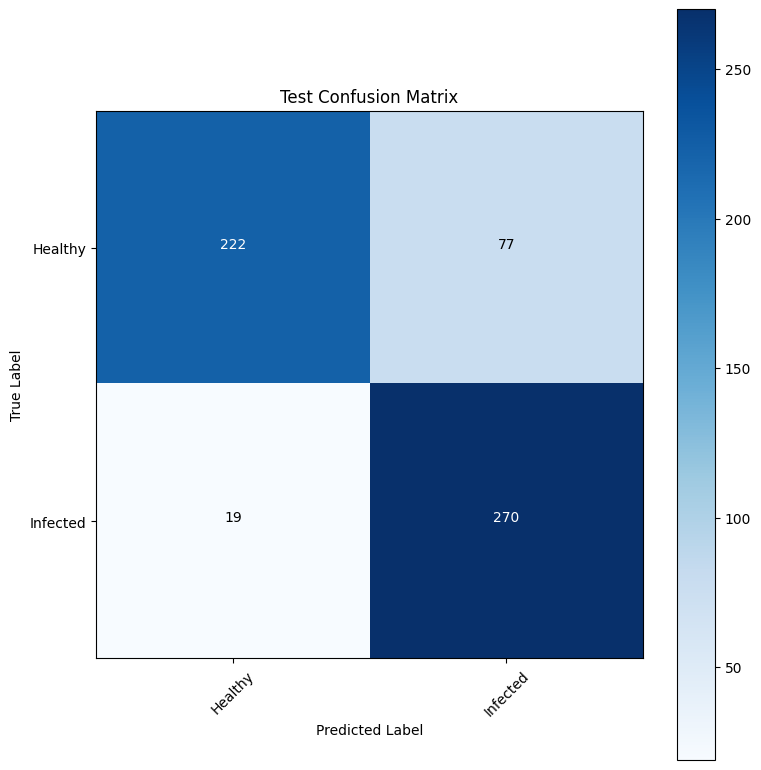

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import itertools

# Set dataset directory
data_dir = './Tea_Leaf_Disease'

# Define image size and batch size
img_height, img_width = 256, 256
batch_size =2

# ImageDataGenerators for train, validation, and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load the saved model
model = tf.keras.models.load_model('best_cnn_model3.h5')

# Define the test data generator
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(data_dir, 'validation'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Predict validation and test data
val_preds = model.predict(validation_generator)
test_preds = model.predict(test_generator)

# Convert predictions to class labels
val_preds_labels = np.argmax(val_preds, axis=1)
test_preds_labels = np.argmax(test_preds, axis=1)

# True labels
val_true_labels = validation_generator.classes
test_true_labels = test_generator.classes

# Get class indices
class_indices = validation_generator.class_indices
class_names = list(class_indices.keys())

# Classification report for validation data
print("Validation Classification Report:")
print(classification_report(val_true_labels, val_preds_labels, target_names=class_names))

# Confusion matrix for validation data
val_cm = confusion_matrix(val_true_labels, val_preds_labels)

# Classification report for test data
print("Test Classification Report:")
print(classification_report(test_true_labels, test_preds_labels, target_names=class_names))

# Confusion matrix for test data
test_cm = confusion_matrix(test_true_labels, test_preds_labels)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

# Plot confusion matrices
plot_confusion_matrix(val_cm, class_names, title='Validation Confusion Matrix')
plot_confusion_matrix(test_cm, class_names, title='Test Confusion Matrix')

# ROC curve for validation data
val_fpr, val_tpr, _ = roc_curve(val_true_labels.ravel(), val_preds.ravel())
val_roc_auc = auc(val_fpr, val_tpr)

# ROC curve for test data
test_fpr, test_tpr, _ = roc_curve(test_true_labels.ravel(), test_preds.ravel())
test_roc_auc = auc(test_fpr, test_tpr)

# Plot ROC curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(val_fpr, val_tpr, label=f'Validation ROC Curve (AUC = {val_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_fpr, test_tpr, label=f'Test ROC Curve (AUC = {test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
import time

# Measure the time it takes to predict test dataset labels
start_time = time.time()
test_preds = model.predict(test_generator)
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to predict test dataset: {elapsed_time:.2f} seconds")

294/294 [==============================] - 6s 19ms/step
Time taken to predict test dataset: 6.38 seconds


In [ ]:
%load_ext tensorboard